In [155]:
import streamlit as st
import pandas as pd
from sqlalchemy import create_engine
import plotly.graph_objects as go
import os
import json
import plotly.express as px
import numpy as np

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"
print(aws_rds_url)

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT * 
                    FROM public.tracking_staging 
                    WHERE date >= CURRENT_DATE - INTERVAL '30 days'
                    LIMIT 30000
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data = data[["size_title", "color1_id", "brand_title", "price_numeric", "status", "catalog_id"]]
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id
0,S / 36 / 8,1.0,Bershka,2,Novo sem etiquetas,1041
1,S / 36 / 8,12.0,Bershka,2,Novo sem etiquetas,1041
2,S / 36 / 8,16.0,Stradivarius,2,Novo sem etiquetas,1041
3,S / 36 / 8,1.0,Stradivarius,2,Novo sem etiquetas,1041
4,S / 36 / 8,4.0,Stradivarius,2,Novo sem etiquetas,534
...,...,...,...,...,...,...
29995,46,3.0,Diadora,20,Muito bom,1242
29996,3 anos / 98 cm,3.0,IKKS,8,Bom,2561
29997,,None,De,3,Satisfatório,1504
29998,,7.0,CUIR,50,Muito bom,156


In [156]:
data.isnull().sum()

size_title          0
color1_id        3742
brand_title         0
price_numeric       0
status              0
catalog_id          0
dtype: int64

In [157]:
data = data.fillna(value = 0)
data.isnull().sum()

size_title       0
color1_id        0
brand_title      0
price_numeric    0
status           0
catalog_id       0
dtype: int64

In [158]:
import re

# preprocessing size into unique formats
def check_string(string_to_check):
    # check size_title and parse sizes into unique sizes
    # M / 36 = M
    if re.match(r'^[a-zA-Z]', string_to_check):
        return (''.join(re.findall(r'[a-zA-Z]', string_to_check)))

    else:
        # first letter starts with a number
        return(string_to_check)
    
data["size_title"] = data["size_title"].apply(check_string)
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id
0,S,1.0,Bershka,2,Novo sem etiquetas,1041
1,S,12.0,Bershka,2,Novo sem etiquetas,1041
2,S,16.0,Stradivarius,2,Novo sem etiquetas,1041
3,S,1.0,Stradivarius,2,Novo sem etiquetas,1041
4,S,4.0,Stradivarius,2,Novo sem etiquetas,534
...,...,...,...,...,...,...
29995,46,3.0,Diadora,20,Muito bom,1242
29996,3 anos / 98 cm,3.0,IKKS,8,Bom,2561
29997,,0,De,3,Satisfatório,1504
29998,,7.0,CUIR,50,Muito bom,156


In [159]:
# create is shoe label
data['is_shoe'] = data['size_title'].apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else 0)
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id,is_shoe
0,S,1.0,Bershka,2,Novo sem etiquetas,1041,0
1,S,12.0,Bershka,2,Novo sem etiquetas,1041,0
2,S,16.0,Stradivarius,2,Novo sem etiquetas,1041,0
3,S,1.0,Stradivarius,2,Novo sem etiquetas,1041,0
4,S,4.0,Stradivarius,2,Novo sem etiquetas,534,0
...,...,...,...,...,...,...,...
29995,46,3.0,Diadora,20,Muito bom,1242,1
29996,3 anos / 98 cm,3.0,IKKS,8,Bom,2561,0
29997,,0,De,3,Satisfatório,1504,0
29998,,7.0,CUIR,50,Muito bom,156,0


In [160]:
data['is_other'] = np.where((data['brand_title'] == '') & (data['size_title'] == ''), 1, 0)
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id,is_shoe,is_other
0,S,1.0,Bershka,2,Novo sem etiquetas,1041,0,0
1,S,12.0,Bershka,2,Novo sem etiquetas,1041,0,0
2,S,16.0,Stradivarius,2,Novo sem etiquetas,1041,0,0
3,S,1.0,Stradivarius,2,Novo sem etiquetas,1041,0,0
4,S,4.0,Stradivarius,2,Novo sem etiquetas,534,0,0
...,...,...,...,...,...,...,...,...
29995,46,3.0,Diadora,20,Muito bom,1242,1,0
29996,3 anos / 98 cm,3.0,IKKS,8,Bom,2561,0,0
29997,,0,De,3,Satisfatório,1504,0,0
29998,,7.0,CUIR,50,Muito bom,156,0,0


In [161]:
data = data[(data["is_shoe"] == 0) & (data["is_other"] == 0)]
data["size_title"].unique()

array(['S', 'M', 'Tamanhonico', 'XXL', 'XL', 'XS', 'L', 'PTW', '',
       '10 anos / 140 cm', '12 anos / 152 cm', 'XXXL', '11 anos / 146 cm',
       '9 anos / 134 cm', '31 mm - 38 mm', 'Prematuroatcm', 'Outro',
       '3-6 meses / 62\xa0cm', '9-12 meses / 74\xa0cm', 'Ajustvel', 'XXS',
       '100 cm', '7 anos / 122 cm', '6-9 meses / 68 cm',
       '24-36 meses / 92 cm', '12-18 meses / 80\xa0cm', '3 anos / 98 cm',
       '13-15', 'XXXS', '44,5', '39 cm', '37 cm', '14 anos / 164 cm',
       '8 anos / 128 cm', '5 anos / 110 cm', '6 anos / 116 cm',
       '4 anos / 104 cm', '18-24 meses / 86\xa0cm', '38 cm',
       '200 cm - 249 cm', '14,9 mm Ø / 6,5', '40,5', '2XL',
       '5XL / 50 / 22', '100 x 150 cm', '16 anos / 176 cm', '4XL',
       '40 x 40 cm', 'Atcm', '45,5', '43 cm', '44 cm', '45 cm',
       '15 anos / 170 cm', '21 mm Ø / 27', '120 cm', '85B',
       '1-3 meses / 56\xa0cm', 'Atmscm', 'Recmnascidoscm', '75A e AA',
       '70A e AA', '65A e AA', '42,5', '4XL / 48 / 20', '47,5', '4

In [162]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 300].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id,is_shoe,is_other
0,S,1.0,Bershka,2,Novo sem etiquetas,1041,0,0
1,S,12.0,Bershka,2,Novo sem etiquetas,1041,0,0
2,S,16.0,Stradivarius,2,Novo sem etiquetas,1041,0,0
3,S,1.0,Stradivarius,2,Novo sem etiquetas,1041,0,0
4,S,4.0,Stradivarius,2,Novo sem etiquetas,534,0,0
...,...,...,...,...,...,...,...,...
29989,,2.0,Calvin Klein,40,Novo sem etiquetas,1140,0,0
29990,S,22.0,Zara,20,Muito bom,1056,0,0
29997,,0,De,3,Satisfatório,1504,0,0
29998,,7.0,CUIR,50,Muito bom,156,0,0


In [163]:
from sklearn.model_selection import train_test_split
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data = data.drop(["is_shoe", "is_other"], axis = 1)
data


,size_title,color1_id,brand_title,price_numeric,status,catalog_id
0,S,1.0,Bershka,2,Novo sem etiquetas,1041
1,S,12.0,Bershka,2,Novo sem etiquetas,1041
2,S,16.0,Stradivarius,2,Novo sem etiquetas,1041
3,S,1.0,Stradivarius,2,Novo sem etiquetas,1041
4,S,4.0,Stradivarius,2,Novo sem etiquetas,534
...,...,...,...,...,...,...
29989,,2.0,Calvin Klein,40,Novo sem etiquetas,1140
29990,S,22.0,Zara,20,Muito bom,1056
29997,,0,De,3,Satisfatório,1504
29998,,7.0,CUIR,50,Muito bom,156


In [164]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15908 entries, 5978 to 23978
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   size_title   15908 non-null  category
 1   color1_id    15908 non-null  category
 2   brand_title  15908 non-null  category
 3   status       15908 non-null  category
 4   catalog_id   15908 non-null  category
dtypes: category(5)
memory usage: 344.4 KB


In [165]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

d_train=lgb.Dataset(X_train, label=y_train)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 400,
    'max_depth': 10,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

y_pred = clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int32)
errors = y_pred - y_test


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1394
[LightGBM] [Info] Number of data points in the train set: 15908, number of used features: 5
[LightGBM] [Info] Start training from score 15.883141


Found `n_estimators` in params. Will use it instead of argument


Mean Squared Error: 1550.407845109379


In [166]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results

,Prediction,Test
0,11,6
1,27,19
2,7,20
3,4,1
4,14,5
...,...,...
3972,49,40
3973,38,10
3974,3,3
3975,11,5


Text(0.5, 1.0, 'Actual vs. Predicted')

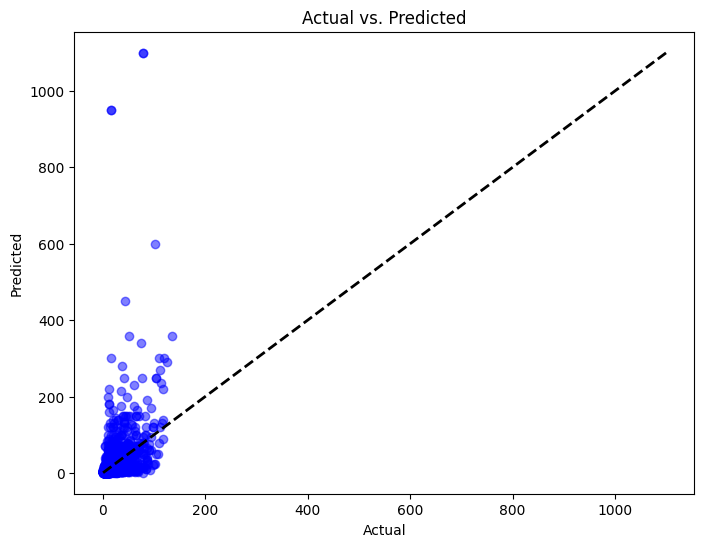

In [167]:
import matplotlib.pyplot as plt

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

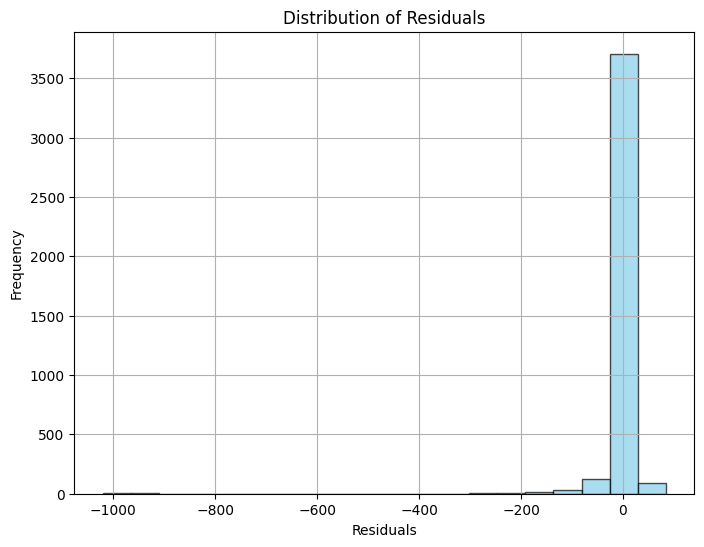

In [168]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

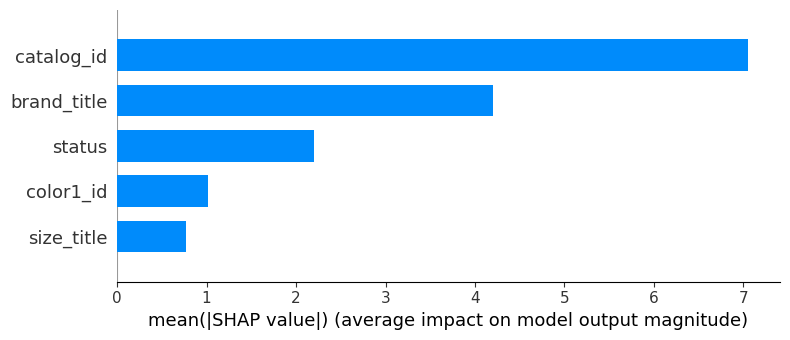

In [169]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

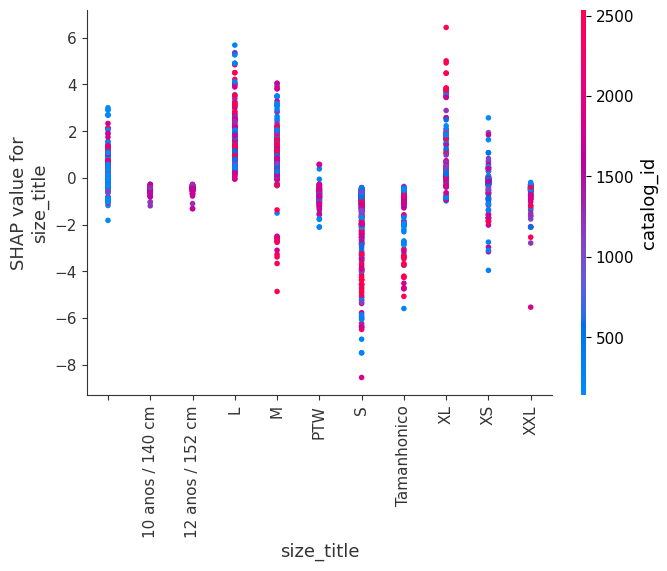

In [170]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")